# 🚕 NYC Taxi ML Model Experiments

This notebook covers the complete ML pipeline:
1. **Feature Analysis** - EDA on engineered features
2. **Feature Selection** - Statistical + RF-based selection
3. **Data Splitting** - Train/Val/Test stratified splits
4. **Model Training** - Baseline (LR, DT) + Advanced (XGBoost, RF)
5. **Evaluation & Optimization** - Hyperparameter tuning

**Target Variables:**
- `fare_amount` - Trip fare prediction
- `trip_duration_minutes` - Duration prediction

## 1. Setup and Imports

In [1]:
# Core imports
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Visualization config
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
warnings.filterwarnings('ignore')

# Add src to path
project_root = Path().cwd().parent
src_path = project_root / 'src'
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(src_path))

print(f"📁 Project root: {project_root}")
print(f"🐍 Python: {sys.version.split()[0]}")
print(f"📊 Pandas: {pd.__version__}")
print(f"🔢 NumPy: {np.__version__}")

📁 Project root: d:\repo\nyc_taxi_project
🐍 Python: 3.12.12
📊 Pandas: 2.3.3
🔢 NumPy: 2.3.5


In [2]:
# Project-specific imports
from config.paths import (FEATURE_DATA, PROCESSED_DIR, BASELINE_MODEL_PATH, 
                          ADVANCED_MODEL_PATH, FARE_MODEL_DATA_FILE, 
                          DURATION_MODEL_DATA_FILE)
from config.settings import RANDOM_STATE, TEST_SIZE, VAL_SIZE
from data.data_splitter import DataSplitter
from data.feature_selector import FeatureSelector
from models.baseline import LinearRegressionModel, DecisionTreeModel
from models.advanced import XGBoostModel, RandomForestModel
from pipelines.train_model import ModelTrainer
from evaluation.metrics import calculate_metrics

print("✅ All project modules imported successfully")
print(f"📂 Feature data: {FEATURE_DATA}")
print(f"🎲 Random state: {RANDOM_STATE}")

✅ All project modules imported successfully
📂 Feature data: d:\repo\nyc_taxi_project\data\processed\feature_data.parquet
🎲 Random state: 42


## 2. Load Feature-Engineered Data

In [3]:
# Load feature-engineered dataset
print("📥 LOADING FEATURE-ENGINEERED DATA")
print("=" * 60)

df = pd.read_parquet(FEATURE_DATA)

print(f"\n📊 DATASET OVERVIEW:")
print(f"   Shape: {df.shape[0]:,} rows × {df.shape[1]} features")
print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Target variables check
targets = ['fare_amount', 'trip_duration_minutes']
print(f"\n🎯 TARGET VARIABLES:")
for target in targets:
    if target in df.columns:
        stats = df[target].describe()
        print(f"   {target}:")
        print(f"      Mean: {stats['mean']:.2f}, Std: {stats['std']:.2f}")
        print(f"      Range: [{stats['min']:.2f}, {stats['max']:.2f}]")

# Feature types summary
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()

print(f"\n📋 FEATURE TYPES:")
print(f"   Numeric: {len(numeric_cols)}")
print(f"   Categorical: {len(categorical_cols)}")
print(f"   Datetime: {len(datetime_cols)}")

📥 LOADING FEATURE-ENGINEERED DATA

📊 DATASET OVERVIEW:
   Shape: 2,704,171 rows × 110 features
   Memory: 2484.20 MB

🎯 TARGET VARIABLES:
   fare_amount:
      Mean: 9.88, Std: 4.11
      Range: [0.01, 23.20]
   trip_duration_minutes:
      Mean: 11.77, Std: 6.10
      Range: [1.00, 29.42]

📋 FEATURE TYPES:
   Numeric: 74
   Categorical: 15
   Datetime: 2


## 3. Exploratory Feature Analysis

📊 TARGET VARIABLE ANALYSIS


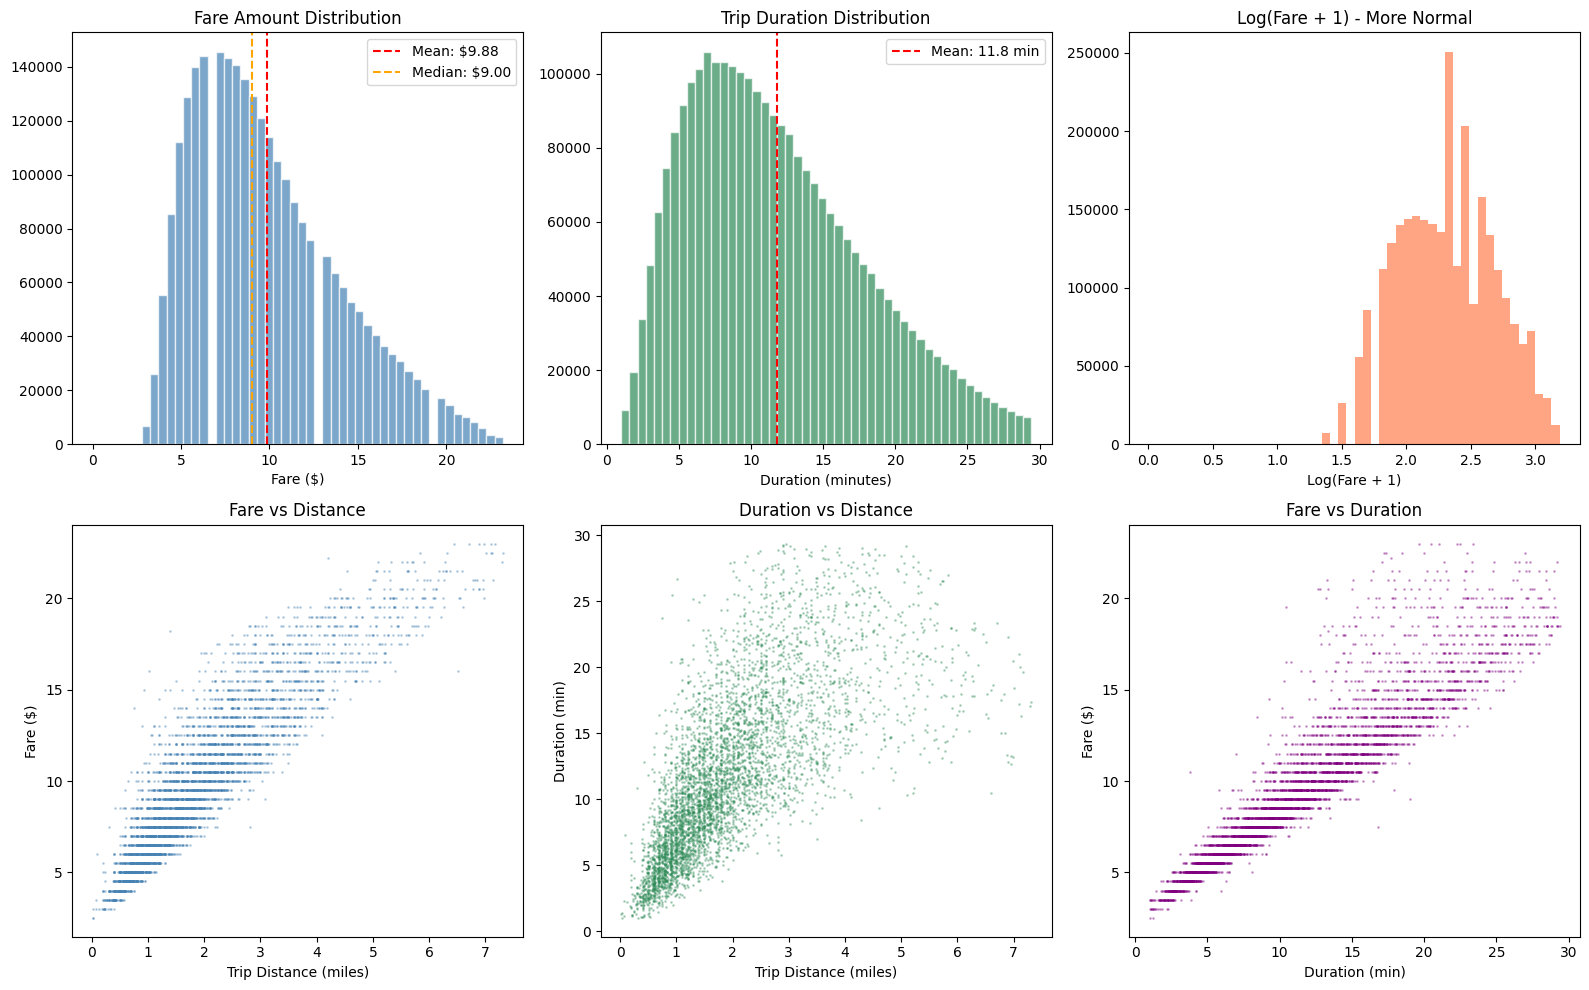


📈 TOP CORRELATIONS WITH TARGETS:

   Fare Amount - Top 10:
      log_fare_amount                r = 0.978
      total_amount                   r = 0.924
      log_trip_distance              r = 0.908
      trip_distance                  r = 0.903
      log_total_amount               r = 0.898
      duration_category_encoded      r = 0.809
      distance_category_encoded      r = 0.801
      trip_efficiency                r = 0.700
      total_amount_category_encoded  r = 0.610
      is_short_distance              r = 0.570

   Trip Duration - Top 10:
      log_fare_amount                r = 0.928
      total_amount                   r = 0.866
      duration_category_encoded      r = 0.866
      log_total_amount               r = 0.854
      log_trip_distance              r = 0.746
      trip_efficiency                r = 0.745
      trip_distance                  r = 0.702
      distance_category_encoded      r = 0.667
      total_amount_category_encoded  r = 0.555
      is_short_dist

In [4]:
# Target variable distributions
print("📊 TARGET VARIABLE ANALYSIS")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Fare amount distribution
axes[0,0].hist(df['fare_amount'], bins=50, alpha=0.7, color='steelblue', edgecolor='white')
axes[0,0].axvline(df['fare_amount'].mean(), color='red', linestyle='--', label=f"Mean: ${df['fare_amount'].mean():.2f}")
axes[0,0].axvline(df['fare_amount'].median(), color='orange', linestyle='--', label=f"Median: ${df['fare_amount'].median():.2f}")
axes[0,0].set_title('Fare Amount Distribution')
axes[0,0].set_xlabel('Fare ($)')
axes[0,0].legend()

# Trip duration distribution
axes[0,1].hist(df['trip_duration_minutes'], bins=50, alpha=0.7, color='seagreen', edgecolor='white')
axes[0,1].axvline(df['trip_duration_minutes'].mean(), color='red', linestyle='--', label=f"Mean: {df['trip_duration_minutes'].mean():.1f} min")
axes[0,1].set_title('Trip Duration Distribution')
axes[0,1].set_xlabel('Duration (minutes)')
axes[0,1].legend()

# Log-transformed distributions (for modeling)
axes[0,2].hist(np.log1p(df['fare_amount']), bins=50, alpha=0.7, color='coral')
axes[0,2].set_title('Log(Fare + 1) - More Normal')
axes[0,2].set_xlabel('Log(Fare + 1)')

# Fare vs Duration scatter
sample = df.sample(min(5000, len(df)), random_state=RANDOM_STATE)
axes[1,0].scatter(sample['trip_distance'], sample['fare_amount'], alpha=0.3, s=1, c='steelblue')
axes[1,0].set_title('Fare vs Distance')
axes[1,0].set_xlabel('Trip Distance (miles)')
axes[1,0].set_ylabel('Fare ($)')

axes[1,1].scatter(sample['trip_distance'], sample['trip_duration_minutes'], alpha=0.3, s=1, c='seagreen')
axes[1,1].set_title('Duration vs Distance')
axes[1,1].set_xlabel('Trip Distance (miles)')
axes[1,1].set_ylabel('Duration (min)')

# Fare vs Duration
axes[1,2].scatter(sample['trip_duration_minutes'], sample['fare_amount'], alpha=0.3, s=1, c='purple')
axes[1,2].set_title('Fare vs Duration')
axes[1,2].set_xlabel('Duration (min)')
axes[1,2].set_ylabel('Fare ($)')

plt.tight_layout()
plt.show()

# Correlation with targets
print("\n📈 TOP CORRELATIONS WITH TARGETS:")
numeric_df = df.select_dtypes(include=[np.number])
corr_fare = numeric_df.corr()['fare_amount'].drop(['fare_amount', 'trip_duration_minutes']).abs().sort_values(ascending=False)
corr_duration = numeric_df.corr()['trip_duration_minutes'].drop(['fare_amount', 'trip_duration_minutes']).abs().sort_values(ascending=False)

print("\n   Fare Amount - Top 10:")
for feat, corr in corr_fare.head(10).items():
    print(f"      {feat:<30} r = {corr:.3f}")

print("\n   Trip Duration - Top 10:")
for feat, corr in corr_duration.head(10).items():
    print(f"      {feat:<30} r = {corr:.3f}")

## 4. Data Splitting & Feature Selection

In [5]:
# Split data and select features using DataSplitter
print("🔀 DATA SPLITTING & FEATURE SELECTION")
print("=" * 60)

# Initialize splitter
splitter = DataSplitter(test_size=TEST_SIZE, val_size=VAL_SIZE, random_state=RANDOM_STATE)

# Split for both models with feature selection
splits = splitter.split_data_for_both_models(df, sample_for_feature_selection=15000)

# Extract split info
split_info = splits['split_info']
print(f"\n📊 SPLIT STATISTICS:")
print(f"   Total samples: {split_info['total_samples']:,}")
print(f"   Train: {split_info['train_samples']:,} ({split_info['train_ratio']:.1%})")
print(f"   Validation: {split_info['val_samples']:,} ({split_info['val_ratio']:.1%})")
print(f"   Test: {split_info['test_samples']:,} ({split_info['test_ratio']:.1%})")

# Fare model features
fare_data = splits['fare_model']
print(f"\n💰 FARE MODEL:")
print(f"   Selected features: {len(fare_data['features'])}")
print(f"   Top 10 features:")
for i, feat in enumerate(fare_data['features'][:10], 1):
    print(f"      {i:2d}. {feat}")

# Duration model features  
duration_data = splits['duration_model']
print(f"\n⏱️ DURATION MODEL:")
print(f"   Selected features: {len(duration_data['features'])}")
print(f"   Top 10 features:")
for i, feat in enumerate(duration_data['features'][:10], 1):
    print(f"      {i:2d}. {feat}")

# Feature overlap analysis
overlap_info = splitter.get_feature_overlap(splits)
print(f"\n🔗 FEATURE OVERLAP:")
print(f"   Shared features: {overlap_info['overlap_count']}")
print(f"   Fare-only features: {overlap_info['fare_only_count']}")
print(f"   Duration-only features: {overlap_info['duration_only_count']}")

🔀 DATA SPLITTING & FEATURE SELECTION


2025-12-18 15:25:55,762 - INFO - Train: 1892919, Val: 270417, Test: 540835
INFO:nyc_taxi_logger:Train: 1892919, Val: 270417, Test: 540835
2025-12-18 15:25:55,958 - INFO - Selecting features for fare model...
INFO:nyc_taxi_logger:Selecting features for fare model...
2025-12-18 15:26:03,145 - INFO - Selecting features for duration model...
INFO:nyc_taxi_logger:Selecting features for duration model...
2025-12-18 15:26:10,072 - INFO - Selected 30 features for fare model
INFO:nyc_taxi_logger:Selected 30 features for fare model
2025-12-18 15:26:10,074 - INFO - Selected 25 features for duration model
INFO:nyc_taxi_logger:Selected 25 features for duration model



📊 SPLIT STATISTICS:
   Total samples: 2,704,171
   Train: 1,892,919 (70.0%)
   Validation: 270,417 (10.0%)
   Test: 540,835 (20.0%)

💰 FARE MODEL:
   Selected features: 30
   Top 10 features:
       1. trip_distance
       2. log_trip_distance
       3. distance_category_encoded
       4. avg_speed_mph
       5. is_short_distance
       6. fare_per_mile
       7. is_medium_distance
       8. dropoff_popularity
       9. pickup_popularity
      10. airport_fee

⏱️ DURATION MODEL:
   Selected features: 25
   Top 10 features:
       1. trip_efficiency
       2. log_trip_distance
       3. trip_distance
       4. distance_category_encoded
       5. is_short_distance
       6. is_very_short_trip
       7. is_medium_distance
       8. is_round_trip
       9. avg_speed_mph
      10. is_slow_trip

🔗 FEATURE OVERLAP:
   Shared features: 13
   Fare-only features: 17
   Duration-only features: 12


📊 FEATURE IMPORTANCE VISUALIZATION


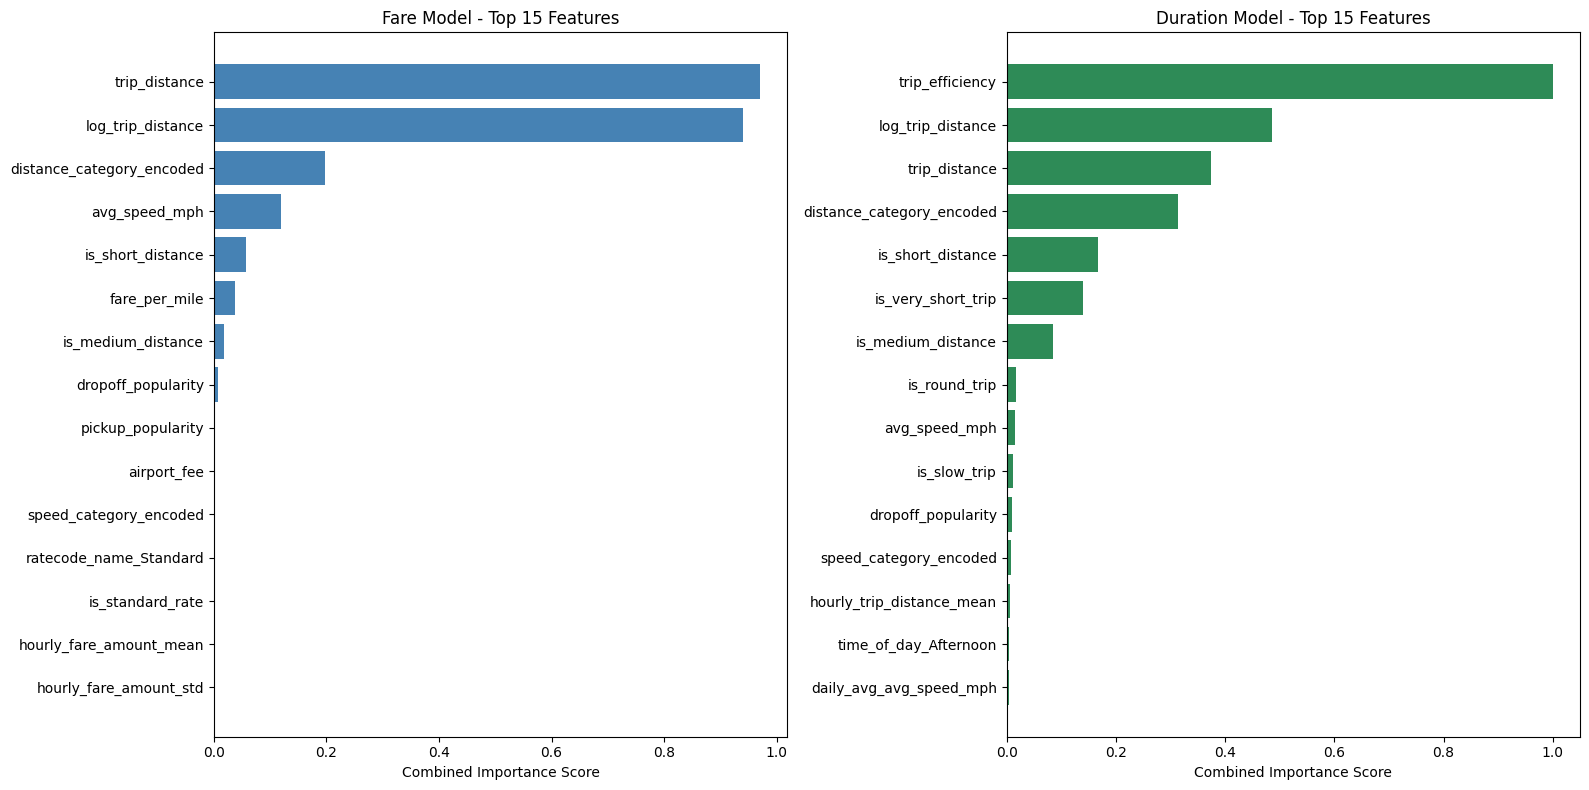


💾 Saving split data for training...
   ✅ Fare model data: d:\repo\nyc_taxi_project\data\processed\fare_model_data.pkl
   ✅ Duration model data: d:\repo\nyc_taxi_project\data\processed\duration_model_data.pkl


In [6]:
# Visualize feature importance scores
print("📊 FEATURE IMPORTANCE VISUALIZATION")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Fare model feature scores
fare_scores = fare_data['feature_scores'].nlargest(15, 'combined_score')
axes[0].barh(fare_scores['feature'], fare_scores['combined_score'], color='steelblue')
axes[0].set_title('Fare Model - Top 15 Features', fontsize=12)
axes[0].set_xlabel('Combined Importance Score')
axes[0].invert_yaxis()

# Duration model feature scores
duration_scores = duration_data['feature_scores'].nlargest(15, 'combined_score')
axes[1].barh(duration_scores['feature'], duration_scores['combined_score'], color='seagreen')
axes[1].set_title('Duration Model - Top 15 Features', fontsize=12)
axes[1].set_xlabel('Combined Importance Score')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Save split data for training pipeline
print("\n💾 Saving split data for training...")
joblib.dump(fare_data, FARE_MODEL_DATA_FILE)
joblib.dump(duration_data, DURATION_MODEL_DATA_FILE)
print(f"   ✅ Fare model data: {FARE_MODEL_DATA_FILE}")
print(f"   ✅ Duration model data: {DURATION_MODEL_DATA_FILE}")

## 5. Baseline Models Training

Training simple models to establish performance baselines:
- **Linear Regression** - Simple, interpretable
- **Decision Tree** - Non-linear, handles interactions

In [7]:
# Train baseline models for FARE prediction
print("🎯 TRAINING BASELINE MODELS - FARE AMOUNT")
print("=" * 60)

# Initialize baseline models for fare
fare_lr = LinearRegressionModel(
    output_path=str(BASELINE_MODEL_PATH),
    target='fare_amount'
)

fare_dt = DecisionTreeModel(
    output_path=str(BASELINE_MODEL_PATH),
    target='fare_amount',
    max_depth=12,
    min_samples_split=50,
    min_samples_leaf=20
)

# Create trainer for fare models
fare_baseline_trainer = ModelTrainer(
    data_path=FARE_MODEL_DATA_FILE,
    models=[fare_lr, fare_dt]
)

# Load data and train
fare_baseline_trainer.load_data()
fare_baseline_trainer.train_model()
fare_baseline_trainer.save_trained_models()
fare_baseline_trainer.print_results_summary()

2025-12-18 15:26:28,491 - INFO - Loading data from data_splitter...
INFO:nyc_taxi_logger:Loading data from data_splitter...


🎯 TRAINING BASELINE MODELS - FARE AMOUNT


2025-12-18 15:26:28,959 - INFO - ✓ Data loaded successfully:
INFO:nyc_taxi_logger:✓ Data loaded successfully:
2025-12-18 15:26:28,974 - INFO -   - X_train: (1892919, 30)
INFO:nyc_taxi_logger:  - X_train: (1892919, 30)
2025-12-18 15:26:28,976 - INFO -   - X_test: (540835, 30)
INFO:nyc_taxi_logger:  - X_test: (540835, 30)
2025-12-18 15:26:28,976 - INFO -   - y_train: (1892919,)
INFO:nyc_taxi_logger:  - y_train: (1892919,)
2025-12-18 15:26:28,976 - INFO -   - y_test: (540835,)
INFO:nyc_taxi_logger:  - y_test: (540835,)
2025-12-18 15:26:28,976 - INFO - Training models...
INFO:nyc_taxi_logger:Training models...
2025-12-18 15:26:28,976 - INFO - 	Training baseline model: linear_regression, Target: fare_amount, Samples: 1892919, Features: 30
INFO:nyc_taxi_logger:	Training baseline model: linear_regression, Target: fare_amount, Samples: 1892919, Features: 30
2025-12-18 15:26:30,724 - INFO - 	Evaluating baseline model: linear_regression ...
INFO:nyc_taxi_logger:	Evaluating baseline model: linear

In [8]:
# Train baseline models for DURATION prediction
print("🎯 TRAINING BASELINE MODELS - TRIP DURATION")
print("=" * 60)

# Initialize baseline models for duration
duration_lr = LinearRegressionModel(
    output_path=str(BASELINE_MODEL_PATH),
    target='trip_duration_minutes'
)

duration_dt = DecisionTreeModel(
    output_path=str(BASELINE_MODEL_PATH),
    target='trip_duration_minutes',
    max_depth=12,
    min_samples_split=50,
    min_samples_leaf=20
)

# Create trainer for duration models
duration_baseline_trainer = ModelTrainer(
    data_path=DURATION_MODEL_DATA_FILE,
    models=[duration_lr, duration_dt]
)

# Load data and train
duration_baseline_trainer.load_data()
duration_baseline_trainer.train_model()
duration_baseline_trainer.save_trained_models()
duration_baseline_trainer.print_results_summary()

2025-12-18 15:26:40,291 - INFO - Loading data from data_splitter...
INFO:nyc_taxi_logger:Loading data from data_splitter...


🎯 TRAINING BASELINE MODELS - TRIP DURATION


2025-12-18 15:26:40,676 - INFO - ✓ Data loaded successfully:
INFO:nyc_taxi_logger:✓ Data loaded successfully:
2025-12-18 15:26:40,676 - INFO -   - X_train: (1892919, 25)
INFO:nyc_taxi_logger:  - X_train: (1892919, 25)
2025-12-18 15:26:40,676 - INFO -   - X_test: (540835, 25)
INFO:nyc_taxi_logger:  - X_test: (540835, 25)
2025-12-18 15:26:40,676 - INFO -   - y_train: (1892919,)
INFO:nyc_taxi_logger:  - y_train: (1892919,)
2025-12-18 15:26:40,676 - INFO -   - y_test: (540835,)
INFO:nyc_taxi_logger:  - y_test: (540835,)
2025-12-18 15:26:40,676 - INFO - Training models...
INFO:nyc_taxi_logger:Training models...
2025-12-18 15:26:40,676 - INFO - 	Training baseline model: linear_regression, Target: trip_duration_minutes, Samples: 1892919, Features: 25
INFO:nyc_taxi_logger:	Training baseline model: linear_regression, Target: trip_duration_minutes, Samples: 1892919, Features: 25
2025-12-18 15:26:41,825 - INFO - 	Evaluating baseline model: linear_regression ...
INFO:nyc_taxi_logger:	Evaluating ba

## 6. Advanced Models Training

Training sophisticated ensemble models:
- **XGBoost** - Gradient boosting with regularization
- **Random Forest** - Bagging ensemble for stability

In [9]:
# Train advanced models for FARE prediction
print("🚀 TRAINING ADVANCED MODELS - FARE AMOUNT")
print("=" * 60)

# Initialize advanced models for fare
fare_xgb = XGBoostModel(
    output_path=str(ADVANCED_MODEL_PATH),
    target='fare_amount',
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.85,
    colsample_bytree=0.85
)

fare_rf = RandomForestModel(
    output_path=str(ADVANCED_MODEL_PATH),
    target='fare_amount',
    n_estimators=150,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10
)

# Create trainer for advanced fare models
fare_advanced_trainer = ModelTrainer(
    data_path=FARE_MODEL_DATA_FILE,
    models=[fare_xgb, fare_rf]
)

# Load data and train
fare_advanced_trainer.load_data()
fare_advanced_trainer.train_model()
fare_advanced_trainer.save_trained_models()
fare_advanced_trainer.print_results_summary()

2025-12-18 15:26:51,114 - INFO - Loading data from data_splitter...
INFO:nyc_taxi_logger:Loading data from data_splitter...


🚀 TRAINING ADVANCED MODELS - FARE AMOUNT


2025-12-18 15:26:51,559 - INFO - ✓ Data loaded successfully:
INFO:nyc_taxi_logger:✓ Data loaded successfully:
2025-12-18 15:26:51,559 - INFO -   - X_train: (1892919, 30)
INFO:nyc_taxi_logger:  - X_train: (1892919, 30)
2025-12-18 15:26:51,569 - INFO -   - X_test: (540835, 30)
INFO:nyc_taxi_logger:  - X_test: (540835, 30)
2025-12-18 15:26:51,569 - INFO -   - y_train: (1892919,)
INFO:nyc_taxi_logger:  - y_train: (1892919,)
2025-12-18 15:26:51,569 - INFO -   - y_test: (540835,)
INFO:nyc_taxi_logger:  - y_test: (540835,)
2025-12-18 15:26:51,571 - INFO - Training models...
INFO:nyc_taxi_logger:Training models...
2025-12-18 15:26:51,571 - INFO - 	Training advanced model: xgboost, Target: fare_amount, Samples: 1892919, Features: 30
INFO:nyc_taxi_logger:	Training advanced model: xgboost, Target: fare_amount, Samples: 1892919, Features: 30
2025-12-18 15:27:10,485 - INFO - 	Evaluating advanced model: xgboost ...
INFO:nyc_taxi_logger:	Evaluating advanced model: xgboost ...
2025-12-18 15:27:13,112 

In [10]:
# Train advanced models for DURATION prediction
print("🚀 TRAINING ADVANCED MODELS - TRIP DURATION")
print("=" * 60)

# Initialize advanced models for duration
duration_xgb = XGBoostModel(
    output_path=str(ADVANCED_MODEL_PATH),
    target='trip_duration_minutes',
    n_estimators=200,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.85,
    colsample_bytree=0.85
)

duration_rf = RandomForestModel(
    output_path=str(ADVANCED_MODEL_PATH),
    target='trip_duration_minutes',
    n_estimators=150,
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10
)

# Create trainer for advanced duration models
duration_advanced_trainer = ModelTrainer(
    data_path=DURATION_MODEL_DATA_FILE,
    models=[duration_xgb, duration_rf]
)

# Load data and train
duration_advanced_trainer.load_data()
duration_advanced_trainer.train_model()
duration_advanced_trainer.save_trained_models()
duration_advanced_trainer.print_results_summary()

2025-12-18 15:28:25,172 - INFO - Loading data from data_splitter...
INFO:nyc_taxi_logger:Loading data from data_splitter...


🚀 TRAINING ADVANCED MODELS - TRIP DURATION


2025-12-18 15:28:25,558 - INFO - ✓ Data loaded successfully:
INFO:nyc_taxi_logger:✓ Data loaded successfully:
2025-12-18 15:28:25,558 - INFO -   - X_train: (1892919, 25)
INFO:nyc_taxi_logger:  - X_train: (1892919, 25)
2025-12-18 15:28:25,558 - INFO -   - X_test: (540835, 25)
INFO:nyc_taxi_logger:  - X_test: (540835, 25)
2025-12-18 15:28:25,558 - INFO -   - y_train: (1892919,)
INFO:nyc_taxi_logger:  - y_train: (1892919,)
2025-12-18 15:28:25,558 - INFO -   - y_test: (540835,)
INFO:nyc_taxi_logger:  - y_test: (540835,)
2025-12-18 15:28:25,558 - INFO - Training models...
INFO:nyc_taxi_logger:Training models...
2025-12-18 15:28:25,558 - INFO - 	Training advanced model: xgboost, Target: trip_duration_minutes, Samples: 1892919, Features: 25
INFO:nyc_taxi_logger:	Training advanced model: xgboost, Target: trip_duration_minutes, Samples: 1892919, Features: 25
2025-12-18 15:28:39,972 - INFO - 	Evaluating advanced model: xgboost ...
INFO:nyc_taxi_logger:	Evaluating advanced model: xgboost ...
2025

## 7. Model Comparison & Evaluation

In [11]:
# Compile all model results for comparison
print("📊 MODEL COMPARISON DASHBOARD")
print("=" * 70)

def compile_results(trainers_dict):
    """Compile results from multiple trainers into comparison DataFrame"""
    results = []
    for target, trainers in trainers_dict.items():
        for trainer in trainers:
            for model_name, model_results in trainer.model_results.items():
                results.append({
                    'Target': target,
                    'Model': model_name,
                    'Type': model_results['model_instance'].model_type,
                    'Train_R2': model_results['train_metrics']['r2'],
                    'Train_RMSE': model_results['train_metrics']['rmse'],
                    'Train_MAE': model_results['train_metrics']['mae'],
                    'Val_R2': model_results['val_metrics']['r2'],
                    'Val_RMSE': model_results['val_metrics']['rmse'],
                    'Val_MAE': model_results['val_metrics']['mae'],
                    'Test_R2': model_results['test_metrics']['r2'],
                    'Test_RMSE': model_results['test_metrics']['rmse'],
                    'Test_MAE': model_results['test_metrics']['mae'],
                })
    return pd.DataFrame(results)

# Compile all results
all_trainers = {
    'fare_amount': [fare_baseline_trainer, fare_advanced_trainer],
    'trip_duration_minutes': [duration_baseline_trainer, duration_advanced_trainer]
}

results_df = compile_results(all_trainers)

# Display results by target
print("\n💰 FARE AMOUNT MODELS:")
fare_results = results_df[results_df['Target'] == 'fare_amount'].sort_values('Test_R2', ascending=False)
display(fare_results[['Model', 'Type', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'Val_R2']].round(4))

print("\n⏱️ TRIP DURATION MODELS:")
duration_results = results_df[results_df['Target'] == 'trip_duration_minutes'].sort_values('Test_R2', ascending=False)
display(duration_results[['Model', 'Type', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'Val_R2']].round(4))

📊 MODEL COMPARISON DASHBOARD

💰 FARE AMOUNT MODELS:


,Model,Type,Test_R2,Test_RMSE,Test_MAE,Val_R2
2,xgboost,advanced,0.9988,0.1415,0.0552,0.9989
0,linear_regression,baseline,0.9450,0.9660,0.6562,0.9443
3,random_forest,advanced,0.9368,1.0352,0.7129,0.9369
1,decision_tree,baseline,0.4714,2.9949,2.3303,0.4729



⏱️ TRIP DURATION MODELS:


,Model,Type,Test_R2,Test_RMSE,Test_MAE,Val_R2
6,xgboost,advanced,0.9999,0.0470,0.0320,0.9999
7,random_forest,advanced,0.9720,1.0221,0.5937,0.9721
4,linear_regression,baseline,0.9091,1.8426,1.2704,0.9077
5,decision_tree,baseline,0.7913,2.7926,2.2383,0.7916


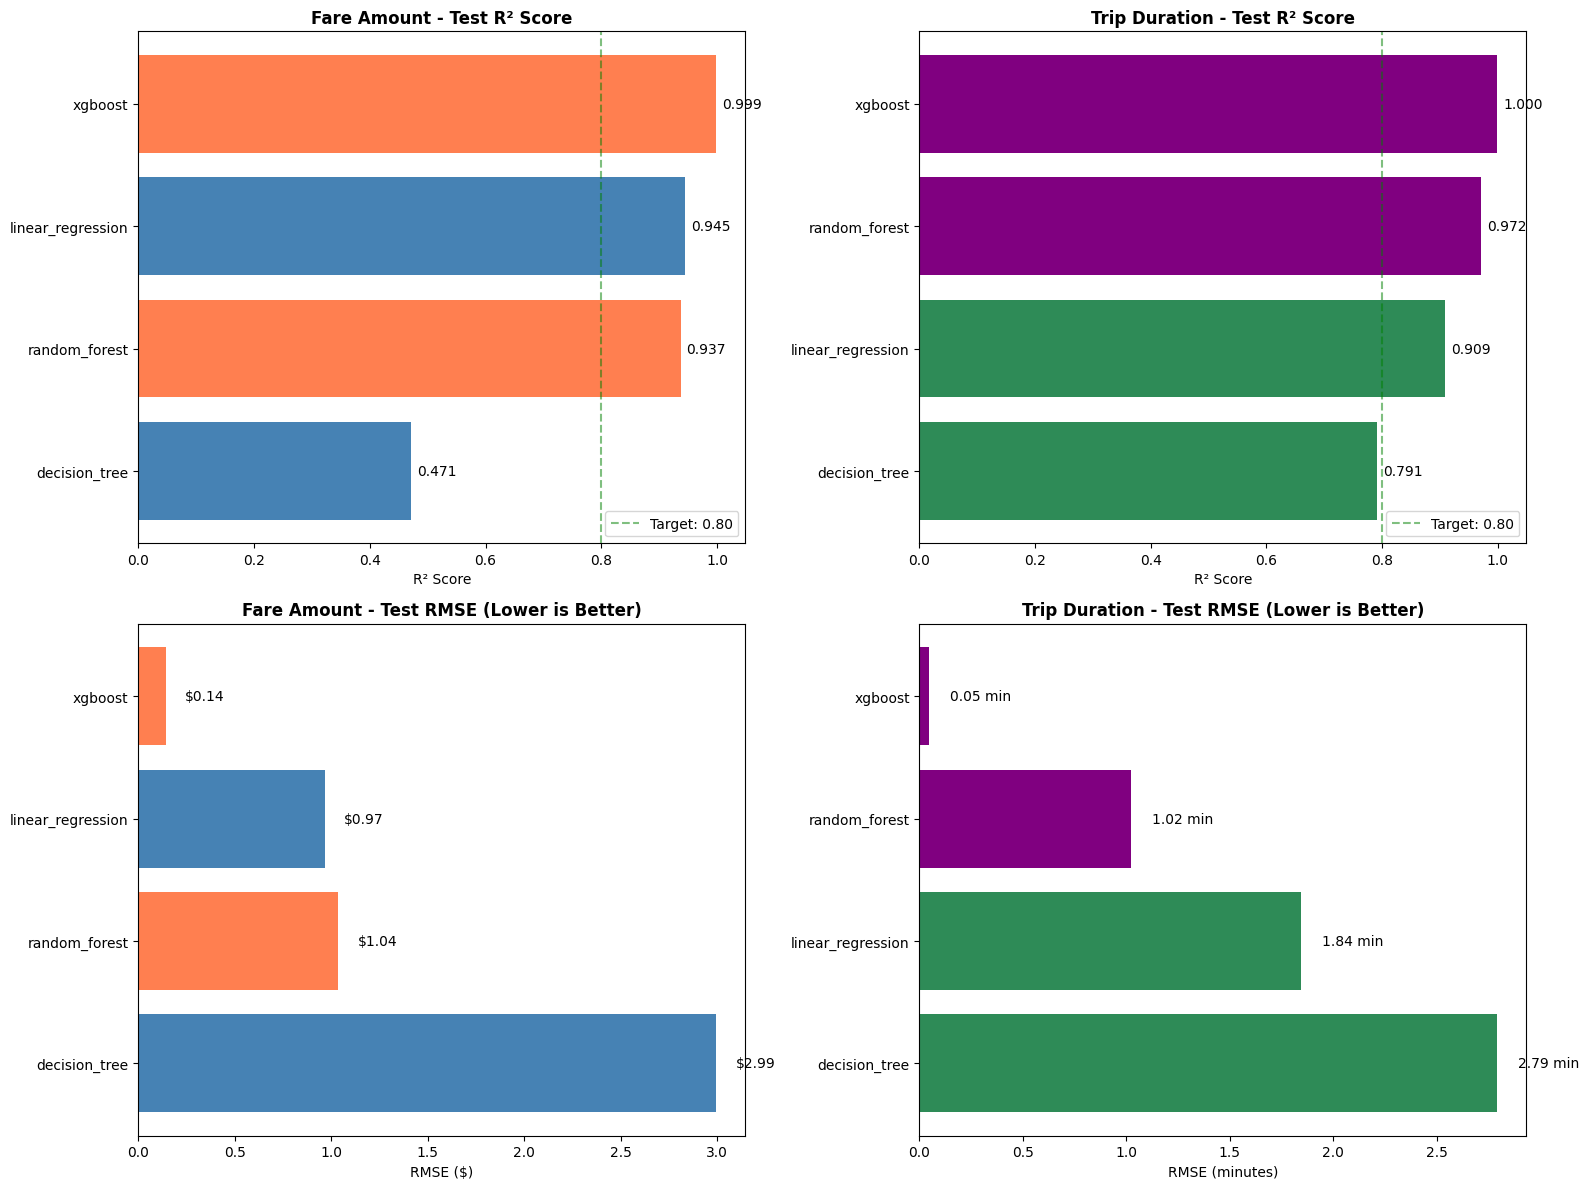


🏆 BEST PERFORMING MODELS:
   💰 Fare: xgboost (R²=0.9988, RMSE=$0.14)
   ⏱️ Duration: xgboost (R²=0.9999, RMSE=0.05 min)


In [12]:
# Visualization: Model Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# R² Comparison - Fare Models
fare_models = results_df[results_df['Target'] == 'fare_amount'].sort_values('Test_R2', ascending=True)
colors_fare = ['steelblue' if t == 'baseline' else 'coral' for t in fare_models['Type']]
axes[0,0].barh(fare_models['Model'], fare_models['Test_R2'], color=colors_fare)
axes[0,0].set_title('Fare Amount - Test R² Score', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('R² Score')
axes[0,0].axvline(x=0.8, color='green', linestyle='--', alpha=0.5, label='Target: 0.80')
for i, (model, r2) in enumerate(zip(fare_models['Model'], fare_models['Test_R2'])):
    axes[0,0].text(r2 + 0.01, i, f'{r2:.3f}', va='center', fontsize=10)
axes[0,0].legend()

# R² Comparison - Duration Models
duration_models = results_df[results_df['Target'] == 'trip_duration_minutes'].sort_values('Test_R2', ascending=True)
colors_dur = ['seagreen' if t == 'baseline' else 'purple' for t in duration_models['Type']]
axes[0,1].barh(duration_models['Model'], duration_models['Test_R2'], color=colors_dur)
axes[0,1].set_title('Trip Duration - Test R² Score', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('R² Score')
axes[0,1].axvline(x=0.8, color='green', linestyle='--', alpha=0.5, label='Target: 0.80')
for i, (model, r2) in enumerate(zip(duration_models['Model'], duration_models['Test_R2'])):
    axes[0,1].text(r2 + 0.01, i, f'{r2:.3f}', va='center', fontsize=10)
axes[0,1].legend()

# RMSE Comparison - Fare
axes[1,0].barh(fare_models['Model'], fare_models['Test_RMSE'], color=colors_fare)
axes[1,0].set_title('Fare Amount - Test RMSE (Lower is Better)', fontsize=12, fontweight='bold')
axes[1,0].set_xlabel('RMSE ($)')
for i, (model, rmse) in enumerate(zip(fare_models['Model'], fare_models['Test_RMSE'])):
    axes[1,0].text(rmse + 0.1, i, f'${rmse:.2f}', va='center', fontsize=10)

# RMSE Comparison - Duration
axes[1,1].barh(duration_models['Model'], duration_models['Test_RMSE'], color=colors_dur)
axes[1,1].set_title('Trip Duration - Test RMSE (Lower is Better)', fontsize=12, fontweight='bold')
axes[1,1].set_xlabel('RMSE (minutes)')
for i, (model, rmse) in enumerate(zip(duration_models['Model'], duration_models['Test_RMSE'])):
    axes[1,1].text(rmse + 0.1, i, f'{rmse:.2f} min', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Identify best models
print("\n🏆 BEST PERFORMING MODELS:")
best_fare = fare_results.iloc[0]
best_duration = duration_results.iloc[0]
print(f"   💰 Fare: {best_fare['Model']} (R²={best_fare['Test_R2']:.4f}, RMSE=${best_fare['Test_RMSE']:.2f})")
print(f"   ⏱️ Duration: {best_duration['Model']} (R²={best_duration['Test_R2']:.4f}, RMSE={best_duration['Test_RMSE']:.2f} min)")

## 8. Prediction Analysis & Error Diagnostics

🔍 PREDICTION ERROR ANALYSIS


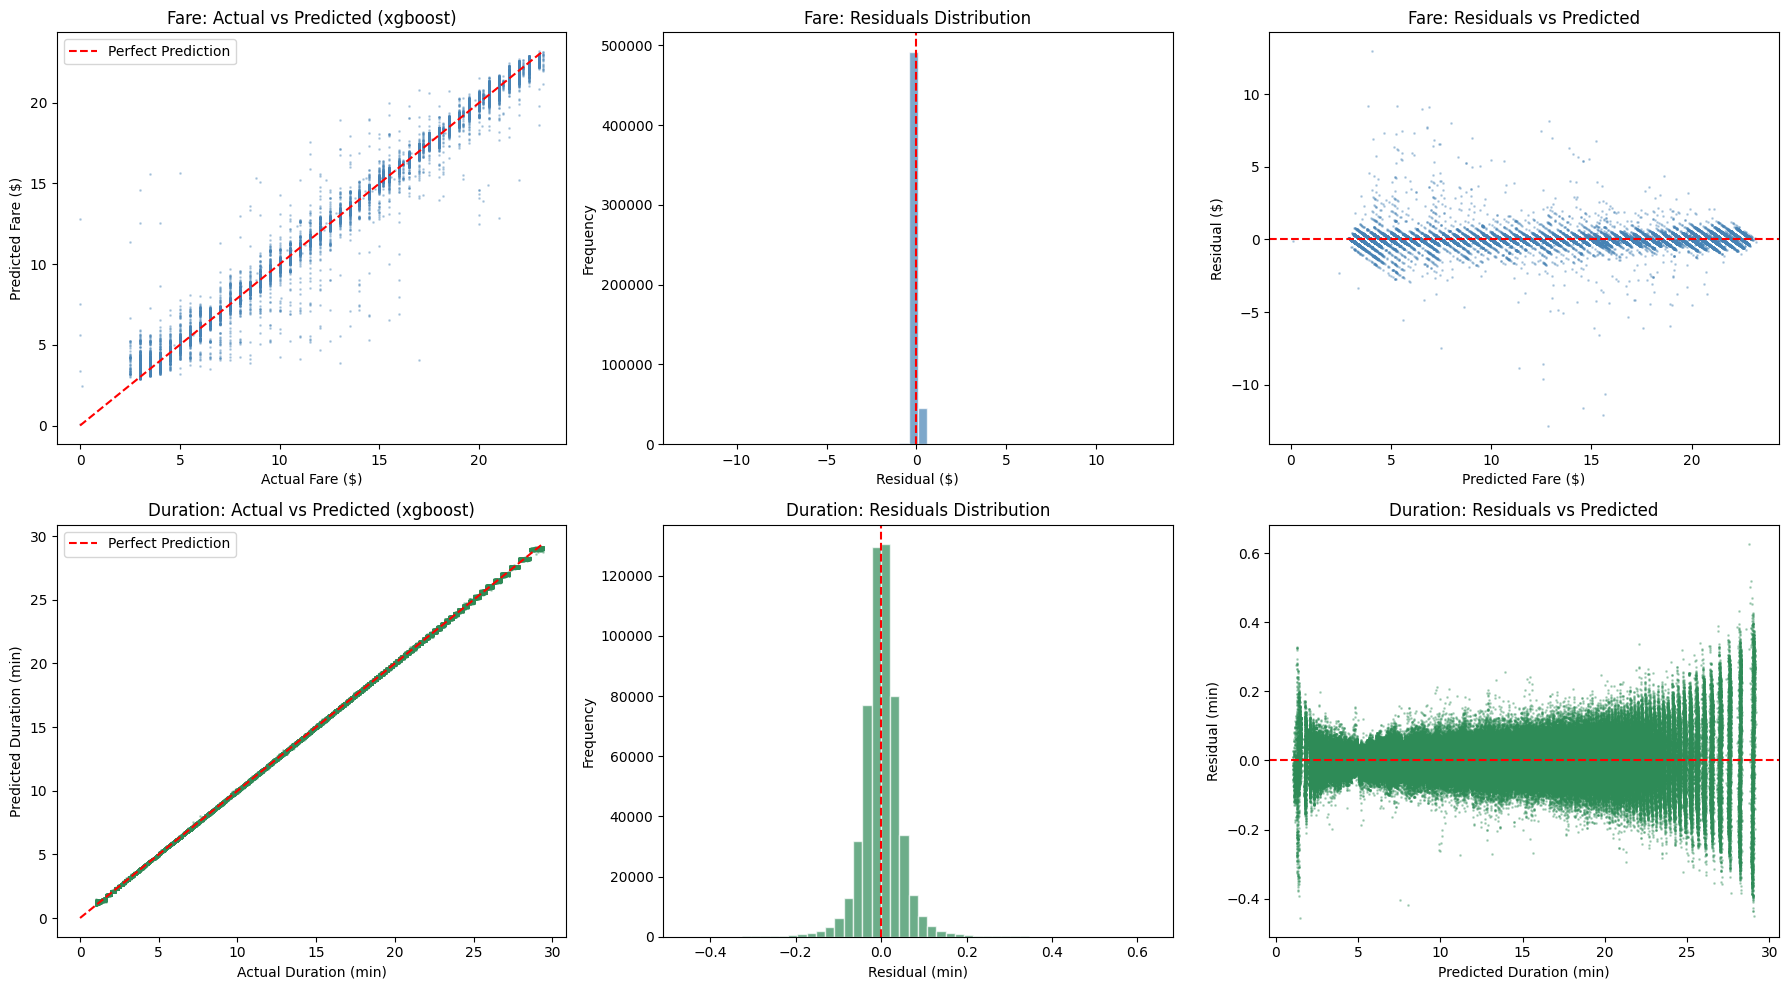


📈 ERROR STATISTICS:

   💰 Fare Model (xgboost):
      Mean Error: $-0.000
      Std Error: $0.142
      95% of errors within: ±$0.28

   ⏱️ Duration Model (xgboost):
      Mean Error: 0.000 min
      Std Error: 0.047 min
      95% of errors within: ±0.09 min


In [13]:
# Detailed prediction analysis for best models
print("🔍 PREDICTION ERROR ANALYSIS")
print("=" * 60)

# Get best fare model predictions
best_fare_trainer = fare_advanced_trainer
best_fare_model = None
for name, results in best_fare_trainer.model_results.items():
    if name == best_fare['Model']:
        best_fare_model = results['model_instance']
        break

# Get best duration model predictions
best_duration_trainer = duration_advanced_trainer
best_duration_model = None
for name, results in best_duration_trainer.model_results.items():
    if name == best_duration['Model']:
        best_duration_model = results['model_instance']
        break

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

if best_fare_model:
    # Fare predictions
    y_fare_test = fare_advanced_trainer.y_test
    y_fare_pred = best_fare_model.predict(fare_advanced_trainer.X_test)
    fare_residuals = y_fare_test - y_fare_pred
    
    # Actual vs Predicted - Fare
    axes[0,0].scatter(y_fare_test, y_fare_pred, alpha=0.3, s=1, c='steelblue')
    max_val = max(y_fare_test.max(), y_fare_pred.max())
    axes[0,0].plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction')
    axes[0,0].set_title(f'Fare: Actual vs Predicted ({best_fare["Model"]})')
    axes[0,0].set_xlabel('Actual Fare ($)')
    axes[0,0].set_ylabel('Predicted Fare ($)')
    axes[0,0].legend()
    
    # Residuals distribution - Fare
    axes[0,1].hist(fare_residuals, bins=50, alpha=0.7, color='steelblue', edgecolor='white')
    axes[0,1].axvline(0, color='red', linestyle='--')
    axes[0,1].set_title('Fare: Residuals Distribution')
    axes[0,1].set_xlabel('Residual ($)')
    axes[0,1].set_ylabel('Frequency')
    
    # Residuals vs Predicted - Fare
    axes[0,2].scatter(y_fare_pred, fare_residuals, alpha=0.3, s=1, c='steelblue')
    axes[0,2].axhline(0, color='red', linestyle='--')
    axes[0,2].set_title('Fare: Residuals vs Predicted')
    axes[0,2].set_xlabel('Predicted Fare ($)')
    axes[0,2].set_ylabel('Residual ($)')

if best_duration_model:
    # Duration predictions
    y_dur_test = duration_advanced_trainer.y_test
    y_dur_pred = best_duration_model.predict(duration_advanced_trainer.X_test)
    dur_residuals = y_dur_test - y_dur_pred
    
    # Actual vs Predicted - Duration
    axes[1,0].scatter(y_dur_test, y_dur_pred, alpha=0.3, s=1, c='seagreen')
    max_val = max(y_dur_test.max(), y_dur_pred.max())
    axes[1,0].plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction')
    axes[1,0].set_title(f'Duration: Actual vs Predicted ({best_duration["Model"]})')
    axes[1,0].set_xlabel('Actual Duration (min)')
    axes[1,0].set_ylabel('Predicted Duration (min)')
    axes[1,0].legend()
    
    # Residuals distribution - Duration
    axes[1,1].hist(dur_residuals, bins=50, alpha=0.7, color='seagreen', edgecolor='white')
    axes[1,1].axvline(0, color='red', linestyle='--')
    axes[1,1].set_title('Duration: Residuals Distribution')
    axes[1,1].set_xlabel('Residual (min)')
    axes[1,1].set_ylabel('Frequency')
    
    # Residuals vs Predicted - Duration
    axes[1,2].scatter(y_dur_pred, dur_residuals, alpha=0.3, s=1, c='seagreen')
    axes[1,2].axhline(0, color='red', linestyle='--')
    axes[1,2].set_title('Duration: Residuals vs Predicted')
    axes[1,2].set_xlabel('Predicted Duration (min)')
    axes[1,2].set_ylabel('Residual (min)')

plt.tight_layout()
plt.show()

# Error statistics
print("\n📈 ERROR STATISTICS:")
if best_fare_model:
    print(f"\n   💰 Fare Model ({best_fare['Model']}):")
    print(f"      Mean Error: ${fare_residuals.mean():.3f}")
    print(f"      Std Error: ${fare_residuals.std():.3f}")
    print(f"      95% of errors within: ±${1.96 * fare_residuals.std():.2f}")

if best_duration_model:
    print(f"\n   ⏱️ Duration Model ({best_duration['Model']}):")
    print(f"      Mean Error: {dur_residuals.mean():.3f} min")
    print(f"      Std Error: {dur_residuals.std():.3f} min")
    print(f"      95% of errors within: ±{1.96 * dur_residuals.std():.2f} min")

In [ ]:
# Compare 5 sample predictions: Actual vs Predicted (XGBoost)
print("🔬 SAMPLE PREDICTIONS COMPARISON (XGBoost)")
print("=" * 80)

# Select 5 random examples from test set
np.random.seed(RANDOM_STATE)
sample_indices = np.random.choice(len(fare_advanced_trainer.X_test), size=5, replace=False)

# Get XGBoost models
xgb_fare_model = None
xgb_duration_model = None
for name, results in fare_advanced_trainer.model_results.items():
    if 'xgboost' in name.lower():
        xgb_fare_model = results['model_instance']
        break
for name, results in duration_advanced_trainer.model_results.items():
    if 'xgboost' in name.lower():
        xgb_duration_model = results['model_instance']
        break

# FARE MODEL - 5 Examples
print("\n💰 FARE AMOUNT - 5 Test Samples:")
print("-" * 80)

fare_X_samples = fare_advanced_trainer.X_test.iloc[sample_indices]
fare_y_actual = fare_advanced_trainer.y_test.iloc[sample_indices]
fare_y_pred = xgb_fare_model.predict(fare_X_samples)

fare_comparison = pd.DataFrame({
    'Actual ($)': fare_y_actual.values,
    'Predicted ($)': fare_y_pred,
    'Error ($)': fare_y_actual.values - fare_y_pred,
    'Error (%)': ((fare_y_actual.values - fare_y_pred) / fare_y_actual.values * 100)
})

# Add key features for context
fare_comparison['Distance (mi)'] = fare_X_samples['trip_distance'].values if 'trip_distance' in fare_X_samples.columns else 'N/A'
fare_comparison['Dist Category'] = fare_X_samples['distance_category_encoded'].values if 'distance_category_encoded' in fare_X_samples.columns else 'N/A'

fare_comparison = fare_comparison[['Distance (mi)', 'Dist Category', 'Actual ($)', 'Predicted ($)', 'Error ($)', 'Error (%)']]
fare_comparison.index = [f'Sample {i+1}' for i in range(5)]
display(fare_comparison.round(2))

# DURATION MODEL - 5 Examples  
print("\n⏱️ TRIP DURATION - 5 Test Samples:")
print("-" * 80)

dur_X_samples = duration_advanced_trainer.X_test.iloc[sample_indices]
dur_y_actual = duration_advanced_trainer.y_test.iloc[sample_indices]
dur_y_pred = xgb_duration_model.predict(dur_X_samples)

dur_comparison = pd.DataFrame({
    'Actual (min)': dur_y_actual.values,
    'Predicted (min)': dur_y_pred,
    'Error (min)': dur_y_actual.values - dur_y_pred,
    'Error (%)': ((dur_y_actual.values - dur_y_pred) / dur_y_actual.values * 100)
})

# Add key features for context
dur_comparison['Distance (mi)'] = dur_X_samples['trip_distance'].values if 'trip_distance' in dur_X_samples.columns else 'N/A'
dur_comparison['Efficiency'] = dur_X_samples['trip_efficiency'].values if 'trip_efficiency' in dur_X_samples.columns else 'N/A'

dur_comparison = dur_comparison[['Distance (mi)', 'Efficiency', 'Actual (min)', 'Predicted (min)', 'Error (min)', 'Error (%)']]
dur_comparison.index = [f'Sample {i+1}' for i in range(5)]
display(dur_comparison.round(2))

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fare comparison bar chart
x = np.arange(5)
width = 0.35
axes[0].bar(x - width/2, fare_comparison['Actual ($)'], width, label='Actual', color='steelblue')
axes[0].bar(x + width/2, fare_comparison['Predicted ($)'], width, label='Predicted', color='coral')
axes[0].set_xlabel('Sample')
axes[0].set_ylabel('Fare ($)')
axes[0].set_title('💰 Fare: Actual vs Predicted (5 Samples)')
axes[0].set_xticks(x)
axes[0].set_xticklabels([f'S{i+1}' for i in range(5)])
axes[0].legend()

# Duration comparison bar chart
axes[1].bar(x - width/2, dur_comparison['Actual (min)'], width, label='Actual', color='seagreen')
axes[1].bar(x + width/2, dur_comparison['Predicted (min)'], width, label='Predicted', color='purple')
axes[1].set_xlabel('Sample')
axes[1].set_ylabel('Duration (min)')
axes[1].set_title('⏱️ Duration: Actual vs Predicted (5 Samples)')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'S{i+1}' for i in range(5)])
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n📊 PREDICTION ACCURACY SUMMARY (5 Samples):")
print(f"   💰 Fare: Mean Abs Error = ${np.abs(fare_comparison['Error ($)']).mean():.2f}, Max Error = ${np.abs(fare_comparison['Error ($)']).max():.2f}")
print(f"   ⏱️ Duration: Mean Abs Error = {np.abs(dur_comparison['Error (min)']).mean():.2f} min, Max Error = {np.abs(dur_comparison['Error (min)']).max():.2f} min")

## 9. Feature Importance Analysis

🎯 FEATURE IMPORTANCE FROM BEST MODELS

💰 TOP 10 FARE FEATURES:
   distance_category_encoded      0.4609
   is_short_distance              0.2931
   is_medium_distance             0.0959
   trip_distance                  0.0680
   log_trip_distance              0.0533
   avg_speed_mph                  0.0113
   fare_per_mile                  0.0052
   speed_category_encoded         0.0045
   is_standard_rate               0.0018
   ratecode_name_Standard         0.0012

⏱️ TOP 10 DURATION FEATURES:
   is_very_short_trip             0.6016
   trip_efficiency                0.1896
   trip_distance                  0.0668
   log_trip_distance              0.0560
   is_slow_trip                   0.0299
   is_medium_distance             0.0213
   avg_speed_mph                  0.0196
   speed_category_encoded         0.0086
   distance_category_encoded      0.0046
   pickup_popularity              0.0005


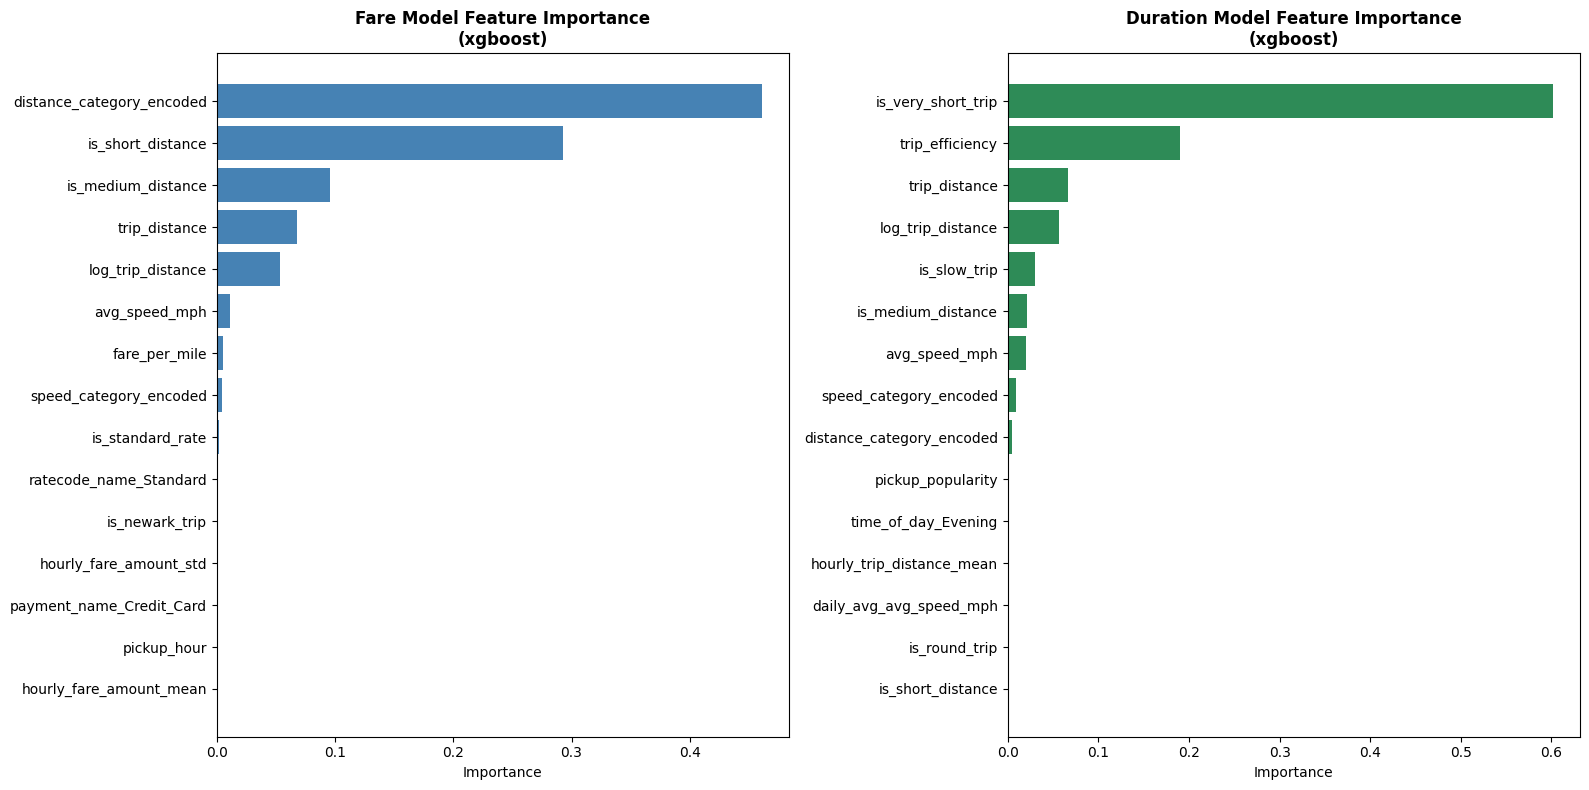

In [14]:
# Extract and visualize feature importance from best models
print("🎯 FEATURE IMPORTANCE FROM BEST MODELS")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Fare model feature importance
if best_fare_model and hasattr(best_fare_model.model, 'feature_importances_'):
    fare_importance = pd.DataFrame({
        'feature': fare_advanced_trainer.features,
        'importance': best_fare_model.model.feature_importances_
    }).sort_values('importance', ascending=True).tail(15)
    
    axes[0].barh(fare_importance['feature'], fare_importance['importance'], color='steelblue')
    axes[0].set_title(f'Fare Model Feature Importance\n({best_fare["Model"]})', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Importance')
    
    print("\n💰 TOP 10 FARE FEATURES:")
    for i, row in fare_importance.tail(10).iloc[::-1].iterrows():
        print(f"   {row['feature']:<30} {row['importance']:.4f}")

# Duration model feature importance
if best_duration_model and hasattr(best_duration_model.model, 'feature_importances_'):
    dur_importance = pd.DataFrame({
        'feature': duration_advanced_trainer.features,
        'importance': best_duration_model.model.feature_importances_
    }).sort_values('importance', ascending=True).tail(15)
    
    axes[1].barh(dur_importance['feature'], dur_importance['importance'], color='seagreen')
    axes[1].set_title(f'Duration Model Feature Importance\n({best_duration["Model"]})', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Importance')
    
    print("\n⏱️ TOP 10 DURATION FEATURES:")
    for i, row in dur_importance.tail(10).iloc[::-1].iterrows():
        print(f"   {row['feature']:<30} {row['importance']:.4f}")

plt.tight_layout()
plt.show()

## 10. Summary & Conclusions

In [15]:
# Final experiment summary
print("=" * 70)
print("📋 ML EXPERIMENT SUMMARY")
print("=" * 70)

print(f"\n📊 DATASET:")
print(f"   Records: {split_info['total_samples']:,}")
print(f"   Fare features: {len(fare_data['features'])}")
print(f"   Duration features: {len(duration_data['features'])}")

print(f"\n🔀 DATA SPLIT:")
print(f"   Train: {split_info['train_samples']:,} ({split_info['train_ratio']:.1%})")
print(f"   Validation: {split_info['val_samples']:,} ({split_info['val_ratio']:.1%})")
print(f"   Test: {split_info['test_samples']:,} ({split_info['test_ratio']:.1%})")

print(f"\n🏆 BEST MODELS:")
print(f"\n   💰 FARE PREDICTION:")
print(f"      Model: {best_fare['Model']}")
print(f"      Test R²: {best_fare['Test_R2']:.4f}")
print(f"      Test RMSE: ${best_fare['Test_RMSE']:.2f}")
print(f"      Test MAE: ${best_fare['Test_MAE']:.2f}")

print(f"\n   ⏱️ DURATION PREDICTION:")
print(f"      Model: {best_duration['Model']}")
print(f"      Test R²: {best_duration['Test_R2']:.4f}")
print(f"      Test RMSE: {best_duration['Test_RMSE']:.2f} min")
print(f"      Test MAE: {best_duration['Test_MAE']:.2f} min")

print(f"\n📈 MODEL IMPROVEMENT (Baseline → Advanced):")
fare_baseline_r2 = fare_results[fare_results['Type'] == 'baseline']['Test_R2'].max()
fare_advanced_r2 = fare_results[fare_results['Type'] == 'advanced']['Test_R2'].max()
dur_baseline_r2 = duration_results[duration_results['Type'] == 'baseline']['Test_R2'].max()
dur_advanced_r2 = duration_results[duration_results['Type'] == 'advanced']['Test_R2'].max()

print(f"   Fare R² improvement: {fare_baseline_r2:.4f} → {fare_advanced_r2:.4f} (+{(fare_advanced_r2 - fare_baseline_r2)*100:.2f}%)")
print(f"   Duration R² improvement: {dur_baseline_r2:.4f} → {dur_advanced_r2:.4f} (+{(dur_advanced_r2 - dur_baseline_r2)*100:.2f}%)")

print(f"\n💾 SAVED ARTIFACTS:")
print(f"   📁 Baseline models: {BASELINE_MODEL_PATH}")
print(f"   📁 Advanced models: {ADVANCED_MODEL_PATH}")
print(f"   📁 Split data: {PROCESSED_DIR}")

print(f"\n🚀 NEXT STEPS:")
print(f"   1. Hyperparameter tuning for top models")
print(f"   2. Cross-validation for robust evaluation")
print(f"   3. Model ensembling (stacking/blending)")
print(f"   4. Production deployment preparation")

print(f"\n✅ EXPERIMENT COMPLETED SUCCESSFULLY!")

📋 ML EXPERIMENT SUMMARY

📊 DATASET:
   Records: 2,704,171
   Fare features: 30
   Duration features: 25

🔀 DATA SPLIT:
   Train: 1,892,919 (70.0%)
   Validation: 270,417 (10.0%)
   Test: 540,835 (20.0%)

🏆 BEST MODELS:

   💰 FARE PREDICTION:
      Model: xgboost
      Test R²: 0.9988
      Test RMSE: $0.14
      Test MAE: $0.06

   ⏱️ DURATION PREDICTION:
      Model: xgboost
      Test R²: 0.9999
      Test RMSE: 0.05 min
      Test MAE: 0.03 min

📈 MODEL IMPROVEMENT (Baseline → Advanced):
   Fare R² improvement: 0.9450 → 0.9988 (+5.38%)
   Duration R² improvement: 0.9091 → 0.9999 (+9.08%)

💾 SAVED ARTIFACTS:
   📁 Baseline models: d:\repo\nyc_taxi_project\models\baseline
   📁 Advanced models: d:\repo\nyc_taxi_project\models\advanced
   📁 Split data: d:\repo\nyc_taxi_project\data\processed

🚀 NEXT STEPS:
   1. Hyperparameter tuning for top models
   2. Cross-validation for robust evaluation
   3. Model ensembling (stacking/blending)
   4. Production deployment preparation

✅ EXPERIMENT